In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rasterio
from sklearn.utils import shuffle
import openslide

import os
import sys
from shutil import copyfile, move
from tqdm import tqdm
import h5py
import random
from random import randint

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import Input
from keras.models import Model
from keras.models import Sequential
from keras.layers import InputLayer, Input
from keras.layers import Conv2D, Dense, Flatten, Dropout, Activation
from keras.layers import BatchNormalization, Reshape, MaxPooling2D, GlobalAveragePooling2D
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.applications import ResNet50, VGG16
from keras.losses import mean_squared_error
import keras as K
from sklearn.metrics import cohen_kappa_score

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11637006128446368181
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7787773952
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4039090426453800790
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [5]:
# TensorFlow에서 GPU를 사용하도록 설정
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)


In [6]:
train_df = pd.read_csv(r"E:\data\prostate-cancer-grade-assessment\train.csv")
image_path = "/data/prostate-cancer-grade-assessment/train_images/"

In [7]:
train_df.head()

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


In [8]:
len(train_df)

10616

In [9]:
image_size = 256
training_sample_percentage = 0.9
training_item_count = int(len(train_df)*training_sample_percentage)
train_df["image_path"] = [image_path+image_id+".tiff" for image_id in train_df["image_id"]]

In [10]:
#remove all image file that don't have a mask file
index_to_drop = []
for idx, row in train_df.iterrows():
    mask_path = row.image_path.replace("train_images","train_label_masks").replace(".tiff","_mask.tiff")

    if not os.path.isfile(mask_path):
        index_to_drop.append(idx)

train_df.drop(index=index_to_drop, axis=0, inplace=True)


(27648, 29440)


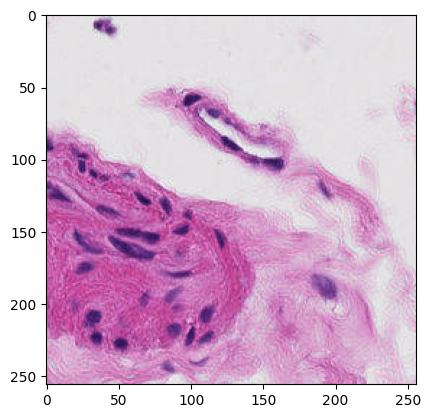

In [11]:
example = openslide.OpenSlide(train_df.iloc[0].image_path)
print(example.dimensions)
clipped_example = example.read_region((5000, 5000), 0, (256, 256))
plt.imshow(clipped_example)
plt.show()

In [12]:
train_df.head()

,image_id,data_provider,isup_grade,gleason_score,image_path
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0,/data/prostate-cancer-grade-assessment/train_i...
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,/data/prostate-cancer-grade-assessment/train_i...
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4,/data/prostate-cancer-grade-assessment/train_i...
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4,/data/prostate-cancer-grade-assessment/train_i...
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0,/data/prostate-cancer-grade-assessment/train_i...


In [13]:
train_df = shuffle(train_df)
validation_df = train_df[training_item_count:]
train_df = train_df[:training_item_count]

In [14]:
def get_single_sample(image_path,image_size=256,training=False,display=False):
    '''
    Return a single 256x256 sample
    with possibility of returning a gleason score using the masks
    '''
    
    image = openslide.OpenSlide(image_path)
    
    mask_path = image_path.replace("train_images","train_label_masks").replace(".tiff","_mask.tiff")
    mask = openslide.OpenSlide(mask_path)
    
    stacked_image = []
    groundtruth_per_image = []
    
    maximum_iteration = 0
    selected_sample = False
    while not selected_sample:
        sampling_start_x = randint(image_size,image.dimensions[0]-image_size)
        sampling_start_y = randint(image_size,image.dimensions[1]-image_size)

        clipped_sample = image.read_region((sampling_start_x, sampling_start_y), 0, (256, 256))
        clipped_array = np.asarray(clipped_sample)
        
        #check that the sample is not empty
        #and use the standard deviation to make sure
        #there is something happening in the sample
        if (not np.all(clipped_array==255) and np.std(clipped_array)>20) or maximum_iteration>200:
            if display:
                plt.imshow(clipped_sample)
                plt.show()
                
            sampled_image = clipped_array[:,:,:3]
            
            if training:
                clipped_mask = mask.read_region((sampling_start_x, sampling_start_y), 0, (256, 256))
                groundtruth_per_image.append(np.mean(np.asarray(clipped_mask)[:,:,0]))
            
            selected_sample = True
        maximum_iteration+=1
    
    if training: 
        return np.array(sampled_image), np.array(groundtruth_per_image)
    else:
        return np.array(sampled_image)

In [15]:
def get_random_samples(image_path,image_size=256,display=False):
    '''
    Load an image and select random areas.
    Return a list of 3 images from areas where there is data.
    '''
    
    image = openslide.OpenSlide(image_path)
    stacked_image = []
    
    selected_samples = 0
    maximum_iteration = 0
    while selected_samples<3:
        sampling_start_x = randint(image_size,image.dimensions[0]-image_size)
        sampling_start_y = randint(image_size,image.dimensions[1]-image_size)

        clipped_sample = image.read_region((sampling_start_x, sampling_start_y), 0, (256, 256))
        clipped_array = np.asarray(clipped_sample)
        
        #check that the sample is not empty
        #and use the standard deviation to make sure
        #there is something happening in the sample
        if (not np.all(clipped_array==255) and np.std(clipped_array)>20) or maximum_iteration>200:
            if display:
                plt.imshow(clipped_sample)
                plt.show()

            stacked_image.append(clipped_array[:,:,:3])
            selected_samples+=1
        maximum_iteration+=1
    return np.array(stacked_image)

In [16]:
get_random_samples(train_df.iloc[0].image_path).shape

(3, 256, 256, 3)

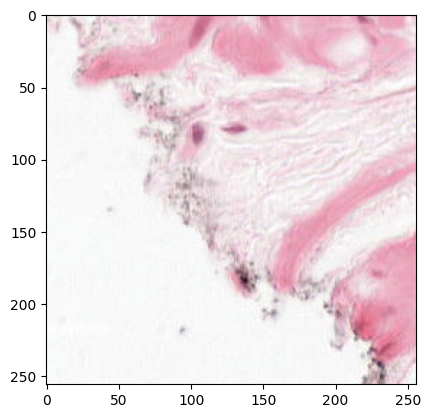

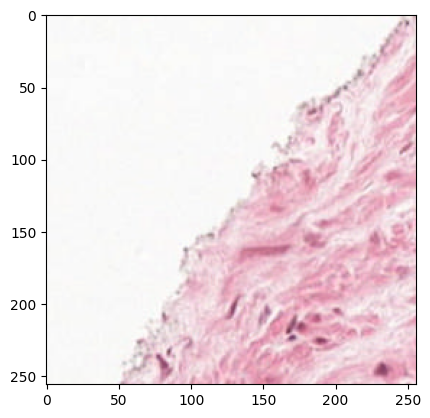

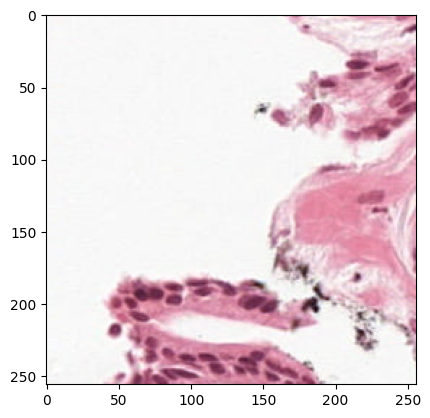

In [17]:
_ = get_random_samples(train_df.iloc[0].image_path, display=True)

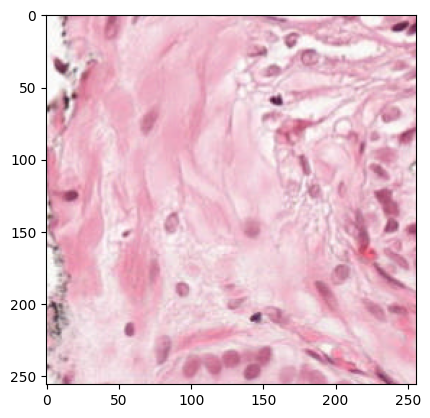

[1.09048462]


In [18]:
output = get_single_sample(train_df.iloc[0].image_path, display=True, training=True)
print(output[1])

In [19]:
def custom_single_image_generator(image_path_list, batch_size=16):
    '''
    return an image and a corresponding gleason score from the mask
    '''
    
    while True:
        for start in range(0, len(image_path_list), batch_size):
            X_batch = []
            Y_batch = []
            end = min(start + batch_size, training_item_count)

            image_info_list = [get_single_sample(image_path, training=True) for image_path in image_path_list[start:end]]
            X_batch = np.array([image_info[0]/255. for image_info in image_info_list])
            Y_batch = np.array([image_info[1] for image_info in image_info_list])
            
            yield X_batch, Y_batch

In [20]:
num_channel = 3
image_shape = (image_size, image_size, num_channel)

def branch(input_image):
    x = Conv2D(128, (3, 3))(input_image)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(64, (3, 3))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(32, (3, 3))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(32, (3, 3))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(32, (3, 3))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = GlobalAveragePooling2D()(x)
    
    x = layers.Dense(256)(x)
    x = Activation('relu')(x)
    
    return layers.Dropout(0.3)(x)

In [21]:
input_image = Input(shape=image_shape)
core_branch = branch(input_image)
output = Dense(1, activation='linear')(core_branch)

branch_model = Model(input_image,output)

In [22]:
branch_model.compile(loss="mse",
                      optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001))
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.5),
             EarlyStopping(monitor='val_loss', patience=3),
             ModelCheckpoint(filepath='best_branch.h5', monitor='val_loss', save_best_only=True)]

batch_size = 16

history = branch_model.fit(custom_single_image_generator(train_df["image_path"], batch_size=batch_size),
                        steps_per_epoch = int(len(train_df)/batch_size),
                        validation_data=custom_single_image_generator(validation_df["image_path"], batch_size=batch_size),
                        validation_steps= int(len(validation_df)/batch_size),
                        epochs=2,
                        callbacks=callbacks)

Epoch 1/2
597/597 [==============================] - 2894s 5s/step - loss: 0.3346 - val_loss: 0.5628 - lr: 0.0010
Epoch 2/2
597/597 [==============================] - ETA: 0s - loss: 0.2700
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
597/597 [==============================] - 1855s 3s/step - loss: 0.2700 - val_loss: 1.2084 - lr: 0.0010


In [23]:
def custom_generator(image_path_list, groundtruth_list, batch_size=16):
    num_classes=6
    while True:
        for start in range(0, len(image_path_list), batch_size):
            X_batch = []
            Y_batch = []
            end = min(start + batch_size, training_item_count)
            
            X_batch = np.array([get_random_samples(image_path)/255. for image_path in image_path_list[start:end]])
            input_image1 = X_batch[:,0,:,:]
            input_image2 = X_batch[:,1,:,:]
            input_image3 = X_batch[:,2,:,:]
            
            Y_batch = tf.keras.utils.to_categorical(np.array(groundtruth_list[start:end]),num_classes) 
            
            yield [input_image1,input_image2,input_image3], Y_batch

In [26]:
def input_branch(input_image):
    '''
    Generate a new input branch using our previous weights
    
    '''
    input_image = Input(shape=image_shape)
    core_branch = branch(input_image)
    output = Dense(1, activation='linear')(core_branch)
    branch_model = Model(input_image,output)
    branch_model.load_weights("./best_branch.h5")
        
    new_branch = Model(inputs=branch_model.input, outputs=branch_model.layers[-2].output)
    
    for layer in new_branch.layers[:-3]:
        layer.trainable = False
    
    return new_branch

In [30]:
input_branch(r'E:\data\prostate-cancer-grade-assessment\train_images\0a8b2cefacdad96c6005799832055629.tiff')

In [33]:
import tensorflow as tf
from keras.models import load_model
import numpy as np

# 모델 파일 (.h5) 경로 지정
model_path = './best_branch.h5'  # 모델 파일의 경로를 적절히 수정하세요

# 모델 불러오기
model = load_model(model_path)

# 예측할 데이터 준비 (이 예제에서는 랜덤 데이터를 사용)
input_shape = model.input_shape[1:]  # 모델의 입력 크기 가져오기
sample_input_data = r'E:\data\prostate-cancer-grade-assessment\train_images\0a8b2cefacdad96c6005799832055629.tiff' # 적절한 입력 데이터를 생성하거나 로드하세요

# 데이터를 모델에 입력하여 예측 수행
predictions = model.predict(sample_input_data)

# 예측 결과 출력
print("Predictions:", predictions)


IndexError: tuple index out of range